In [1]:
# based on and adapted from the xilinx DSP-PYNQ repo: https://github.com/Xilinx/DSP-PYNQ/

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from pynq import Overlay
from pynq import Xlnk
from pynq import allocate
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config IPCompleter.greedy=True
mpl.rcParams['agg.path.chunksize'] = 10000
#sns.set()

In [4]:
xlnk = Xlnk()

In [5]:
# load the compiled overlay bitstream
ol = Overlay('fft.bit')

In [6]:
# check if the axi dma blocks are recognized
list(ol.ip_dict.keys())

['dma_data_pl_to_ps', 'dma_config_ps_to_pl', 'dma_data_ps_to_pl']

In [7]:
# # check if the register map shows up
# ol.fft_data.register_map

In [8]:
# load the audio file on which we are going to do the FFT
from scipy.io import wavfile
import numpy as np

fs, aud_in = wavfile.read("birds.wav")

In [9]:
# utility function to calculate signal to noise ratio between two signals
def SQNR(X_id, X_q):
    return 10*np.log10(np.mean(np.square(np.absolute(X_id))) / np.mean(np.square(np.absolute(X_q - X_id))))


# utility function to convert a frequency domain to a dataframe
def to_freq_dataframe(samples, fs):
    """Create a pandas dataframe from an ndarray frequency domain samples"""
    sample_freqs = np.linspace(0, fs, len(samples))
    return pd.DataFrame(dict(
        amplitude = samples[0:int(len(samples)/2)],  
        freq      = sample_freqs[0:int(len(samples)/2)]
    ))

In [10]:
# pointers to the axi dma blocks
fft_data_in = ol.dma_data_ps_to_pl
fft_data_out = ol.dma_data_pl_to_ps
fft_config = ol.dma_config_ps_to_pl

In [11]:
# utility function to pack config numbers into a double byte value
def get_config_value(forwards, scaling_sched):
    val = 0
    for scaling in scaling_sched:     # [14:1] = scaling schedule
        val = (val << 2) + scaling
    return (val << 1) + int(forwards) # [0] = direction

# create the config value
config_value = get_config_value(True, [2, 2, 2, 2, 2, 2, 2])

#config_value = 1 # forward FFT, no scaling

# create CMA buffer and lay the config value in it
fft_buffer_config = xlnk.cma_array(shape=(1,),dtype=np.int16)
#fft_buffer_config = allocate(shape=(1,),dtype=np.int8)

fft_buffer_config[0] = config_value
# send the config value and wait for confirmation
fft_config.sendchannel.transfer(fft_buffer_config)
fft_config.sendchannel.wait()

In [12]:
# xilinx FFT expects complex numbers with 16-bit components, real part in lower 2 bytes, imag part in upper 2 bytes
# convert our 16 bit input to 32 bit with all imag as zero
aud_hw = np.asarray(aud_in,np.int32)

In [13]:
# FFT size
N = 2**14
# make sure the synthesized design has at least this size of support! check settings of fft block (transform length)

In [14]:
N

16384

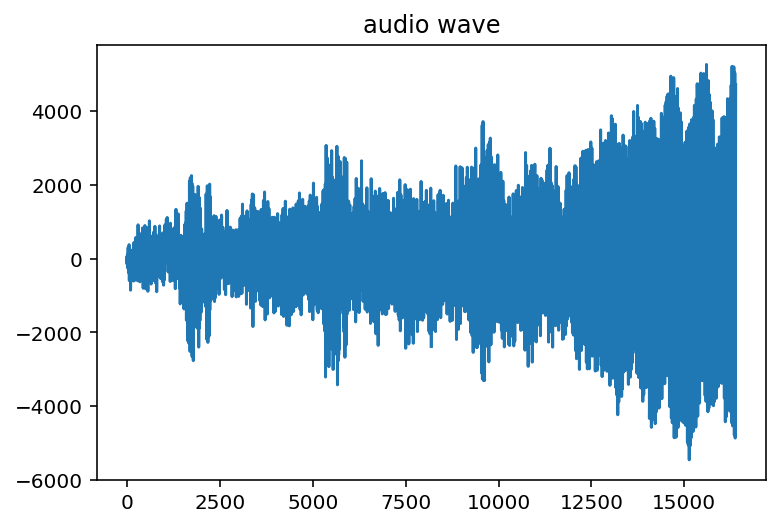

In [15]:
# select the audio input and plot it
offset = np.int16(fs*0.3)
aud_data = aud_hw[offset:offset+N]
plt.plot(aud_data)
plt.title('audio wave');

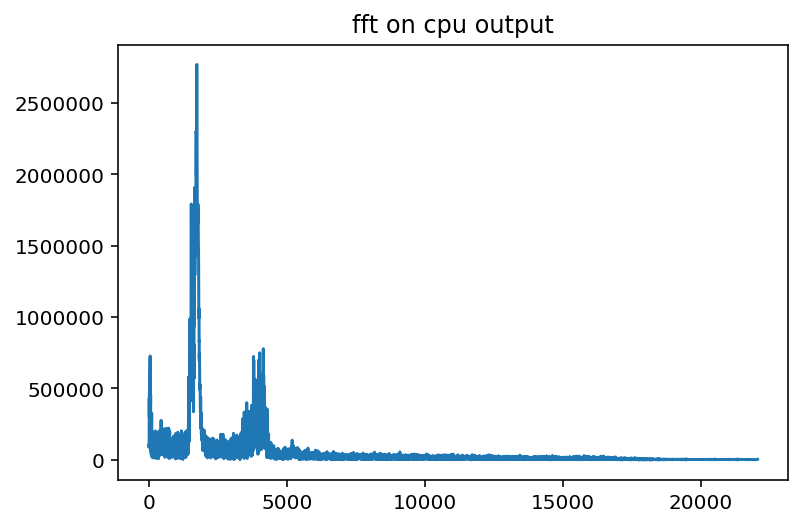

In [16]:
# calculate the fft on cpu and plot it
fft_cpu_out = np.fft.fft(aud_data)
df_cpu = to_freq_dataframe(fft_cpu_out, fs)
plt.plot(df_cpu['freq'], abs(df_cpu['amplitude']))
plt.title('fft on cpu output');

In [17]:
# FFT is assumed to be setup in non real time throttle scheme, so for every frame of data in we read one out
# setup buffers of both input and output
fft_in_buffer = xlnk.cma_array(shape=(N,),dtype=np.int32)
fft_out_buffer = xlnk.cma_array(shape=(N*2,),dtype=np.int16) # convert to 2 16 bit numbers for total of 2*N 16 bit numbers
# memcpy the input data into the buffer
np.copyto(fft_in_buffer, aud_data)
# trigger the dma transfers for send and receive, this will trigger the FFT too
fft_data_in.sendchannel.transfer(fft_in_buffer)
fft_data_in.sendchannel.wait()

In [18]:
fft_data_out.recvchannel.transfer(fft_out_buffer)
fft_data_out.recvchannel.wait()

In [19]:
# read out the result
fft_fpga_out = np.zeros(shape=(N*2,), dtype=np.int16)
np.copyto(fft_fpga_out, fft_out_buffer)

In [20]:
# clean up the buffers
fft_out_buffer.close()
fft_in_buffer.close()

In [21]:
# utility function to create sublists of length n from list l
def divide_chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [22]:
# convert the result to complex numpy type
fft_fpga_out = np.array([np.complex(x[0],x[1]) for x in divide_chunks(fft_fpga_out,2)], dtype=np.complex)

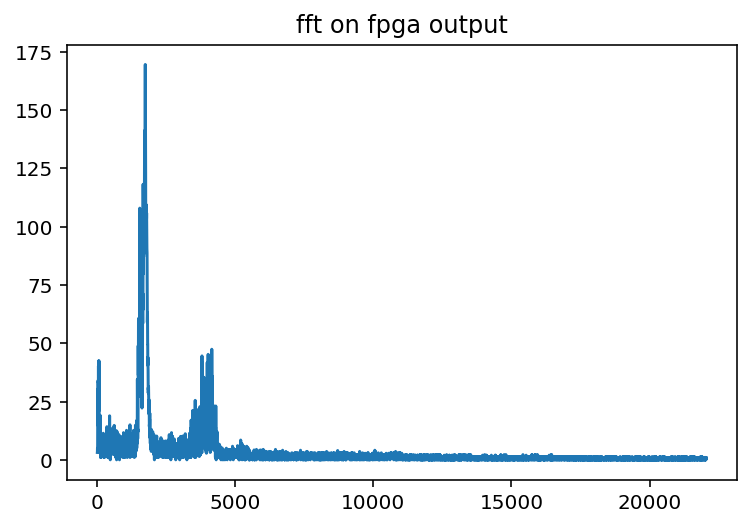

In [23]:
# plot the result
df_fpga = to_freq_dataframe(fft_fpga_out, fs)
plt.plot(df_fpga['freq'], abs(df_fpga['amplitude']))
plt.title('fft on fpga output');

In [24]:
SQNR(fft_cpu_out/N, fft_fpga_out)

22.087491820114206

In [ ]:
np.log2(16384/4)

In [ ]:
2**12